In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/Documents/git_workspace/16715/dynamics-simulation-leg/scripts/Project.toml`


In [2]:
using RigidBodyDynamics
using LinearAlgebra
using MeshCatMechanisms
using MeshCat
using StaticArrays
using ForwardDiff

WebIO._IJuliaInit()

In [3]:
# world = RigidBody{Float64}("world")
# doublependulum = Mechanism(world; gravity = SVector(0, 0, g))
curdir = pwd()
urdfpath = joinpath(curdir, "../res/flyhopper_robot/urdf/flyhopper_robot.urdf")
doublependulum = parse_urdf(urdfpath, floating=false)
state = MechanismState(doublependulum)

MechanismState{Float64, Float64, Float64, …}(…)

In [4]:
const N = 4 # of links

# link lengths
const l0 = 0.1
const l1 = 0.3
const l2 = 0.3
const l3 = 0.1
const l4 = 0.2
const l5 = 0.0205
const lee = sqrt((l3 + l4)^2 + l5^2)

# CoM locations
const l_c0x = 0.0125108364230515
const l_c0y = 0.00117191218927888
const l_c0 = sqrt(l_c0x^2 + l_c0y^2)
const alpha0 = atan(l_c0y, l_c0x)

const l_c1 = 0.149359714867044

const l_c2 = 0.0469412900551914

const l_ceex = 0.113177000131857
const l_ceey = -0.015332867880069
const l_cee = sqrt(l_ceex^2 + l_ceey^2)
const alpha3 = atan(l_ceey, l_ceex)
const alphaee = atan(l5, l3+l4)

# link masses
const m0 = 0.24644240965487
const m1 = 0.0707939028219395
const m2 = 0.276735496985514
const m3 = 0.130824780046739

const g = 9.807

# mass moment of inertia in axis of rotation
const I0 = 0.000172067745507247  # iyy
const I1 = 0.000147960574744097
const I2 = 0.000302324068012293
const I3 = 0.000164188445564489

0.000164188445564489

In [5]:
function kinematics(q)
    #Input: q is an N-dimensional vector of joint angles
    #Output: r is 3×N dimensional vector of global x,y,θ coordinates of each link
    
    r = zeros(eltype(q),3,N)
    #q0 = q[1]
    #q1 = q[2]
    #q2 = q[3]
    #q3 = q[4]
    
    r[1, 1] = l_c0*cos(q[1] + alpha0)
    r[2, 1] = l_c0*sin(q[1] + alpha0)
    r[3, 1] = q[1]
    
    r[1, 2] = l0*cos(q[1]) + l_c1*cos(q[1] + q[2])
    r[2, 2] = l0*sin(q[1]) + l_c1*sin(q[1] + q[2])
    r[3, 2] = q[2]# + q[1]
    
    r[1, 3] = l_c2*cos(q[3])
    r[2, 3] = l_c2*sin(q[3])
    r[3, 3] = q[3]
    
    r[1, 4] = l2*cos(q[3]) + l_cee*cos(q[3] + q[4] + alpha3)
    r[2, 4] = l2*sin(q[3]) + l_cee*sin(q[3] + q[4] + alpha3)
    r[3, 4] = q[4]# + q[3]
    
    #output is r stacked as a single vector
    return vec(r)  # should be 12x1
end

kinematics (generic function with 1 method)

In [199]:
function potential(q)
    #Input: q is an N-dimensional vector of joint angles 
    #Output: U is potential energy
    
    # TODO: return the potential energy 
    # hint, you can use reshape(kinematics(q),3,N) to turn the kinematics back into a 3xN array 
    r = reshape(kinematics(q),3,N)
    U = zero(eltype(q))
    m = Diagonal([m0, m1, m2, m3])
    y = reshape(r[2, :], 4, 1)
    U = sum(m*y.*9.81)
    
    return U
end

potential (generic function with 1 method)

In [200]:
function kinetic(q,q̇)
    #Input: q is an N-dimensional vector of joint angles, q̇ is an N-dimensional vector of joint velocities
    #Output: T is kinetic energy
    
    # TODO: output kinetic energy 
    
    T = zero(eltype([q;q̇]))
    delxy = ForwardDiff.jacobian(kinematics, q)  # 12x4
    delx = delxy[1:3:end, :]
    dely = delxy[2:3:end, :]
    dxdt = delx*q̇
    dydt = dely*q̇
    v_squared = dxdt.^2 + dydt.^2
    q_dot = zeros(eltype([q;q̇]), length(q̇))
    q_dot[1:2] = cumsum(q̇[1:2])  # separate legs
    q_dot[3:4] = cumsum(q̇[3:4])
    
    m = Diagonal([m0, m1, m2, m3])
    J = Diagonal([I0, I1, I2, I3])
    T = sum(0.5*m*v_squared + 0.5*J*(q_dot.^2))
    
    return T
end


kinetic (generic function with 1 method)

In [201]:
function Lagrangian(q,q̇)
    Lag = zero(eltype([q;q̇]))
    Lag = kinetic(q,q̇) - potential(q)
    return Lag
end

Lagrangian (generic function with 1 method)

In [202]:
#Lagrangian derivativess
function D1L(q,q̇)  # del/delq
    return ForwardDiff.gradient(dq->Lagrangian(dq,q̇),q)
end

function D2L(q,q̇)  # del/delqdot
    return ForwardDiff.gradient(dq̇->Lagrangian(q,dq̇),q̇)
end

function D2D2L(q,q̇)  # del/delqdot (del/delqdot)
    return ForwardDiff.jacobian(dq̇->D2L(q,dq̇),q̇)
end

function D1D2L(q,q̇)  # del/delq (del/delqdot)
    return ForwardDiff.jacobian(dq->D2L(dq,q̇),q)
end

D1D2L (generic function with 1 method)

In [203]:
function Mq(q)
    #Input: q is an N-dimensional vector of joint angles
    #Output: M is an N×N positive-definite mass matrix
        
    Jac = ForwardDiff.jacobian(kinematics, q)  # 12x4
    M_bar = I(12).*[m0 m0 1 m1 m1 1 m2 m2 1 m3 m3 1]
    M_bar[3, 3] = I0
    M_bar[6, 6] = I1
    M_bar[9, 9] = I2
    M_bar[12, 12] = I3
    _M = zeros(eltype(q),length(q),length(q))
    _M = Jac'*M_bar*Jac
    
    return _M
end

Mq (generic function with 1 method)

In [204]:
function Cq(q,q̇)
    #Input: q is an N-dimensional vector of joint angles
    #Output: C is an N-dimensional coriolis force vector
    
    # _C = zeros(eltype([q,q̇]),length(q))
    
    delTdelq = ForwardDiff.gradient(_q->kinetic(_q, q̇),q)
    _C = D1D2L(q,q̇)*q̇ - delTdelq# + D1L(q, q̇)# - c*q̇
    
    return _C
end

Cq (generic function with 1 method)

In [205]:
function Gq(q)
    #Input: q is an N-dimensional vector of joint angles
    #Output: G is an N-dimensional gravitational force vector

    _G = zeros(eltype(q),length(q))
    _G = ForwardDiff.gradient(_q->potential(_q),q)
    
    return _G
end

Gq (generic function with 1 method)

In [206]:
function constraint(q)    
    
    x0 = l0*cos(q[1])
    y0 = l0*sin(q[1])
    x1 = x0 + l1*cos(q[1] + q[2])
    y1 = y0 + l1*sin(q[1] + q[2])
    
    # constraint forward kinematics
    xc = l2*cos(q[3]) + l3*cos(q[3] + q[4])
    yc = l2*sin(q[3]) + l3*sin(q[3] + q[4])
    
    c = zeros(eltype(q), 2)
    c[1] = x1 - xc
    c[2] = y1 - yc
    
    return c
end

constraint (generic function with 1 method)

In [207]:
function constraint_jac(q)
    # D = zeros(eltype(q), 2)
    D = ForwardDiff.jacobian(_q -> constraint(_q), q)
    return D
end

constraint_jac (generic function with 1 method)

In [208]:
function dqdot(q, q̇)
    D = constraint_jac(q)
    dqdot = D * q̇
    return dqdot
end

dqdot (generic function with 1 method)

In [209]:
function derivative_constraint_jac(q, q̇)
    # Compute del/delq(D(q)q_dot)q_dot
    d = ForwardDiff.jacobian(_q -> dqdot(_q, q̇), q) * q̇
    return d
end

derivative_constraint_jac (generic function with 1 method)

In [210]:
function cdot(q, q̇)
    #Compute cdot (first derivative of constraint function)
    D = constraint_jac(q)
    q̇ = reshape(q̇, 4, 1)
    cdot = (D*q̇)'
    # cdot = q̇' * D'
    return cdot
end

cdot (generic function with 1 method)

In [226]:
function f(x)
    # parallel mechanism dynamics
    
    q = x[1:N]
    q̇ = x[N+1:end]
    
    # Constraint fn
    c = constraint(q)
    
    # Constraint Jacobian
    D = constraint_jac(q)
    
    # del/delq(D*qdot)*qdot
    d = derivative_constraint_jac(q, q̇)
    
    # first derivative of constraint fn
    cd = cdot(q, q̇)'
    
    ẋ = zeros(eltype(x),length(x))
    
    # Mass matrix
    M = Mq(q)
    
    # Coriolis matrix
    C = Cq(q, q̇)
    
    # Potential matrix
    G = Gq(q)
    
    α = 10
    β = 0.01
    
    e = D*(M\(D'*(α*c + β*cd)))
    
    KKT = [M -D';
           D zeros(2,2)]
    RHS = [- G - C;
           -(d + e)]
    
    sol = KKT\RHS
    λ = sol[N+1:end]
    
    ẋ[1:N] = q̇
    ẋ[N+1:end] = copy(sol[1:4])  # q double dot
    
    return ẋ
end

f (generic function with 1 method)

In [227]:
function checkval(val, max, name)
    if val > max
        @show val
        error(name)
    end
end
#=
#---#
if isnan(qdd[1])
    @show qdd
    error("A!")
end
#---#
=#

checkval (generic function with 1 method)

In [228]:
function rk4_step(f,xk,h)

    f1 = f(xk)
    f2 = f(xk + 0.5*h*f1)
    f3 = f(xk + 0.5*h*f2)
    f4 = f(xk + h*f3)
    
    xn = xk + (h/6.0).*(f1 + 2*f2 + 2*f3 + f4)

    return xn
end

rk4_step (generic function with 1 method)

In [229]:
Tf = 10.0
h = 0.001 #20 Hz
n = Int(floor(Tf./h + 1))
thist = h.*Array(0:(n-1));

In [230]:
function simulate!(xtraj, n)
    for k = 1:(n-1)
        xtraj[:,k+1] .= rk4_step(f, copy(xtraj[:,k]), h)
    end
end

simulate! (generic function with 1 method)

In [231]:
x0 = [-30*pi/180; -120*(pi/180); -150*(pi/180); 120*(pi/180); 0.0; 0.0; 0.0; 0.0]
xtraj = zeros(8,n)
xtraj[:,1] = x0;

In [232]:
simulate!(xtraj, n)

In [233]:
q0 = -xtraj[1, :] .- 30*(pi/180)
q1 = -xtraj[2, :] .- 120*(pi/180)
q2 = -xtraj[3, :] .- 150*(pi/180)
q3 = -xtraj[4, :] .+ 120*(pi/180)

qs = convert(AbstractArray{Float64}, [q0 q2 q1 q3]) 
ts = convert(AbstractVector{Float64}, thist) # AbstractVector(thist)
q_array = [ qs[i,:] for i in 1:size(qs,1)] 

10001-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0]
 [2.218747921278741e-5, -1.4436011211316213e-5, -3.662349042388158e-5, 3.662349042388158e-5]
 [8.875157525201072e-5, -5.77446992462427e-5, -0.00014649627449836444, 0.00014649627449836444]
 [0.0001996972639187744, -0.0001299280278277415, -0.0003296252917466269, 0.0003296252917466269]
 [0.00035503284020466097, -0.00023098927154929783, -0.0005860221117539588, 0.0005860221117539588]
 [0.0005547699212806734, -0.00036093301845863124, -0.0009157029397393046, 0.0009157029397393046]
 [0.00079892345068866, -0.000519765173679243, -0.001318688624367681, 0.001318688624367681]
 [0.0010875117037426607, -0.0007074929640649152, -0.001795004667807465, 0.001795004667807465]
 [0.0014205562941497218, -0.0009241249438969312, -0.00234468123804632, 0.00234468123804632]
 [0.0017980821818612824, -0.0011696710016191325, -0.002967753183480415, 0.002967753183480415]
 [0.0022201176821690094, -0.0014441423676210263, -0.0036642600497898137, 0.00366426004978

In [234]:
# mvis = MechanismVisualizer(doublependulum, Skeleton(randomize_colors=true, inertias=false));
mvis = MechanismVisualizer(doublependulum, URDFVisuals(urdfpath));

render(mvis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8720
└ @ MeshCat /home/ben/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("world" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("base_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x62, 0x61, 0x73, 0x65, 0x5f, 0x6c, 0x69, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_1" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "Link 2" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6c, 0x64, 0x2f, 0x4c, 0x69, 0x6e, 0x6b, 0x20, 0x32], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("Link 3" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6b, 0x20, 0x32, 0x2f, 0x4c, 0x69, 0x6e, 0x6b, 0x20, 0x33], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_Joint 3" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x65, 0x72, 0x5f, 0x4a, 0x6f, 0x69, 0x6e, 0x74, 0x20, 0x33], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_5" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x35], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x35], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "after_Joint 2" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x65, 0x72, 0x5f, 0x4a, 0x6f, 0x69, 0x6e, 0x74, 0x20, 0x32], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_4" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x34], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x34], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "Link 0" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6c, 0x64, 0x2f, 0x4c, 0x69, 0x6e, 0x6b, 0x20, 0x30], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("Link 1" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6b, 0x20, 0x30, 0x2f, 0x4c, 0x69, 0x6e, 0x6b, 0x20, 0x31], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_Joint 1" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x65, 0x72, 0x5f, 0x4a, 0x6f, 0x69, 0x6e, 0x74, 0x20, 0x31], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_3" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x33], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69

In [235]:
# [q0 q2 q1 q3]
set_configuration!(mvis, [-x0[3]-150*(pi/180), -x0[1]-30*(pi/180), -x0[4]+120*(pi/180), -x0[2]-120*(pi/180)])

In [236]:
# Now we can simply call `simulate`, which will return a tuple consisting of:
# * simulation times (a `Vector` of numbers)
# * joint configuration vectors (a `Vector` of `Vector`s)
# * joint velocity vectors (a `Vector` of `Vector`s)

#animation = Animation(mvis, ts, -q_array)
#setanimation!(mvis, animation)

MeshCatMechanisms.animate(mvis, ts, -q_array; realtimerate = 1.);

In [237]:
#Energy Functions

function H(x)
    q = x[1:N]
    q̇ = x[N+1:end]
    energy = Lagrangian(q,q̇)
    return energy
end

H (generic function with 1 method)

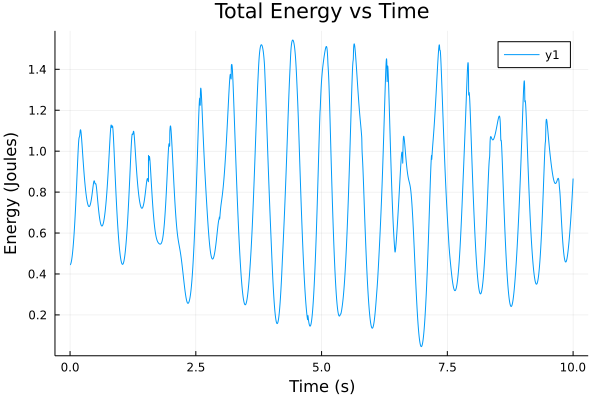

In [238]:
#Plot total energy
using Plots

E = zeros(n)
for k = 1:n
    E[k] = H(xtraj[:, k])
end

plot(thist,E, title="Total Energy vs Time", xlabel="Time (s)", ylabel="Energy (Joules)")